In [2]:
import nltk
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
84324,Woman to file case against Yogi over her nude ...,A tribal woman in Assam will file a defamation...
92446,US prepares charges to seek arrest of Assange:...,US authorities have prepared charges to seek t...
27587,Ford Europe CEO trolls Tesla's Elon Musk over ...,After Tesla announced it has achieved the mile...
24382,Samsung regains lead from Xiaomi in Indian sma...,Samsung has toppled Xiaomi to regain the top s...
73545,Ram Rahim has 19 Guinness world records to his...,Self-styled Godman Gurmeet Ram Rahim has 19 Gu...
46895,"Man to get Ã¢ÂÂ¹1,878 refund from Flipkart af...",A Bengaluru court has ordered e-commerce start...
89291,No Ã¢ÂÂ¹200 cap on movie tickets on weekends ...,The Karnataka High Court has ruled that the ca...
85777,Hindustan Unilever CEO Sanjiv Mehta made Ã¢ÂÂ...,FMCG major Hindustan Unilever's CEO Sanjiv Meh...
32160,Principal's husband booked for groping student...,A residential government school principal's hu...
91884,"Dear Baby, You gave me strength I didn't know ...",In an Instagram post thanking her unborn child...


# Step 2. 데이터 전처리하기 (추상적 요약)

## 중복 샘플과 NULL값 삭제

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


NULL값은 없다.

## 텍스트 정규화와 불용어 제거

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
import nltk
nltk.download('stopwords')

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


419.1293611526489  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

In [10]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [11]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

NULL 값이 없다.

## 훈련데이터와 테스트데이터 나누기

### 1. 샘플의 최대 길이 설정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


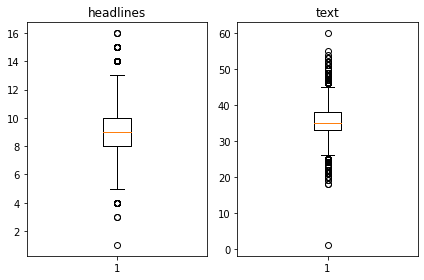

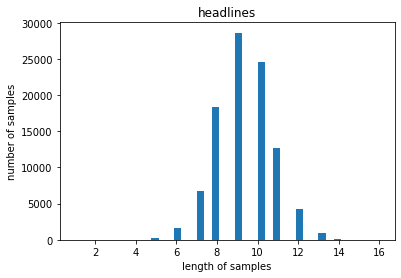

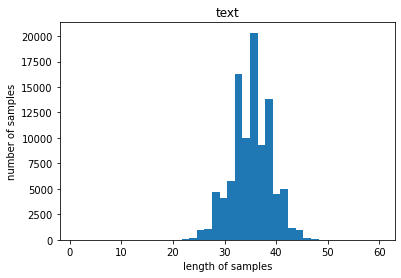

In [12]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

지나치게 큰 길이가 긴 데이터가 없으므로 따로 데이터 처리를 하지 않는다.

### 2. 시작 토큰과 종료 토큰 추가하기

In [13]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [14]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [15]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[63673 13919 25945 ... 73977  9216 31944]


In [16]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### 3. 훈련 데이터와 테스트 데이터 8:2 비율로 나누기

In [17]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [18]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 정수 인코딩

In [19]:
# 단어 집합 만들기 및 정수 인코딩
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [20]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69605
등장 빈도가 6번 이하인 희귀 단어의 수: 47477
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22128
단어 집합에서 희귀 단어의 비율: 68.20918037497307
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.484941637030777


In [21]:
# 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기가 22246개 이므로
# 단어 집합의 크기를 22,000개로 제한
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [22]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[28, 438, 14, 418, 36, 93, 2057, 86, 1, 8413, 554, 296, 119, 1097, 10, 4362, 16681, 2042, 739, 7683, 2895, 3212, 3511, 408, 248, 10, 1610, 862, 21, 554, 296], [204, 4502, 146, 5877, 77, 2813, 1, 8538, 1256, 72, 280, 2157, 14829, 10227, 174, 1386, 14829, 217, 1057, 3158, 174, 1, 146, 3009, 694, 60, 1256, 4836, 95, 4275, 472, 147, 1017, 335, 3299, 108], [4363, 37, 119, 8, 95, 280, 1240, 390, 11578, 1301, 898, 46, 5393, 2356, 86, 1, 103, 280, 995, 333, 4208, 2162, 11578, 101, 1383, 1353, 497, 333, 4208, 2411, 3859, 1123, 1330, 362, 362, 4]]


In [23]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [24]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30063
등장 빈도가 5번 이하인 희귀 단어의 수: 19653
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10410
단어 집합에서 희귀 단어의 비율: 65.37271729368327
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.638982555234355


In [25]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 57, 7665, 9510, 3038, 1360, 6478, 1041], [1, 2385, 599, 1345, 3, 961, 58, 2506, 146, 385], [1, 596, 136, 3101, 221, 10, 286, 2089, 1874], [1, 3497, 1141, 3, 105, 3909, 3, 3695, 261, 3696], [1, 274, 167, 1292, 4854, 424, 164, 3, 21, 3910, 757]]
target
decoder  [[57, 7665, 9510, 3038, 1360, 6478, 1041, 2], [2385, 599, 1345, 3, 961, 58, 2506, 146, 385, 2], [596, 136, 3101, 221, 10, 286, 2089, 1874, 2], [3497, 1141, 3, 105, 3909, 3, 3695, 261, 3696, 2], [274, 167, 1292, 4854, 424, 164, 3, 21, 3910, 757, 2]]


In [26]:
# 훈련데이터와 테스트 데이터에서 요약문의 길이가 1인 경우의 인덱스를 뽑아서 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [27]:
# text의 최대 길이 60, headlines의 최대 길이 16에 맞춰서 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=60, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=60, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=16, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=16, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=16, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=16, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

## 모델 설계하기

In [28]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

text_max_len=60


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [29]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [30]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [31]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [32]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련하기

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 323s 1s/step - loss: 4.6825 - val_loss: 3.9353
Epoch 2/50
308/308 [==============================] - 310s 1s/step - loss: 3.8832 - val_loss: 3.6300
Epoch 3/50
308/308 [==============================] - 313s 1s/step - loss: 3.5825 - val_loss: 3.4173
Epoch 4/50
308/308 [==============================] - 309s 1s/step - loss: 3.3505 - val_loss: 3.2920
Epoch 5/50
308/308 [==============================] - 308s 999ms/step - loss: 3.1872 - val_loss: 3.1768
Epoch 6/50
308/308 [==============================] - 308s 999ms/step - loss: 3.0606 - val_loss: 3.0930
Epoch 7/50
308/308 [==============================] - 308s 999ms/step - loss: 2.9426 - val_loss: 3.0240
Epoch 8/50
308/308 [==============================] - 308s 1s/step - loss: 2.8480 - val_loss: 2.9750
Epoch 9/50
308/308 [==============================] - 308s 999ms/step - loss: 2.7614 - val_loss: 2.9248
Epoch 10/50
308/308 [==============================] - 308s 1s/step - loss: 2.6

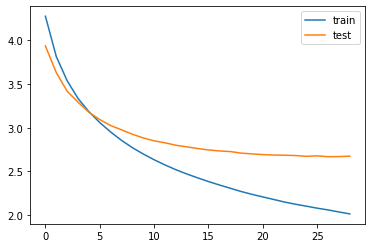

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

## 인퍼런스 모델 

In [35]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [36]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [37]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [38]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트하기

In [39]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [40]:
summary_max_len = 16
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : maharashtra government sunday approved bank guarantees loan related sanctions four mumbai metro projects approved bank guarantee metro issued debt sustainability certificate metro metro metro projects help loan agreements asian development bank asian infrastructure investment bank funding projects 
실제 요약 : maharashtra approves bank for metro projects 
예측 요약 :  maha govt to cut loan waiver to cut costs


원문 : actress sushmita sen shared pictures little black dress instagram message body positivity wrote perfect every size wrote live healthy body let one tell otherwise actress paired dress black sunglasses 
실제 요약 : sushmita shares pics in dress to talk about body 
예측 요약 :  sushmita shares picture with her sister on her dress


원문 : promotional film upcoming russian presidential elections president vladimir putin revealed german chancellor angela merkel sends bottles beer time time putin said enjoyed drinking beer worked soviet union security agent eastern germany 
실제 요약 : angela mer

# Step 5. Summa을 이용해서 추출적 요약해보기

In [47]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
orig_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [48]:
import requests
from summa.summarizer import summarize

In [49]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [50]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [51]:
for i in range(10):
    print("원문 : \n ", orig_data['text'][i])
    print("실제 요약 : \n ", orig_data['headlines'][i])
    print("예측 요약 : \n ", summarize(orig_data['text'][i], ratio=0.5))
    print("\n")

원문 : 
  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : 
  upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : 
  upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : 
  Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : 
  Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : 
  Users get one CRED coin per

# 회고

- 오랜 시간 들여서 모델을 학습시킨것 치고 결과가 좋지 않게 나와서 실망스러웠다.
- 트랜스포머를 적용하고 싶어서 많은 공부를 했지만, 결과적으로 에러가 많이 나서 하지 못했다. 시간이 더 있다면 해볼 것 같다.
- rnn처럼 순차적으로 처리하는 것이 아니라 병렬 처리를 해서 문장 순서를 외우는 방식인 트랜스포머를 사용하면 많은 향상이 있을 것으로 예상한다.

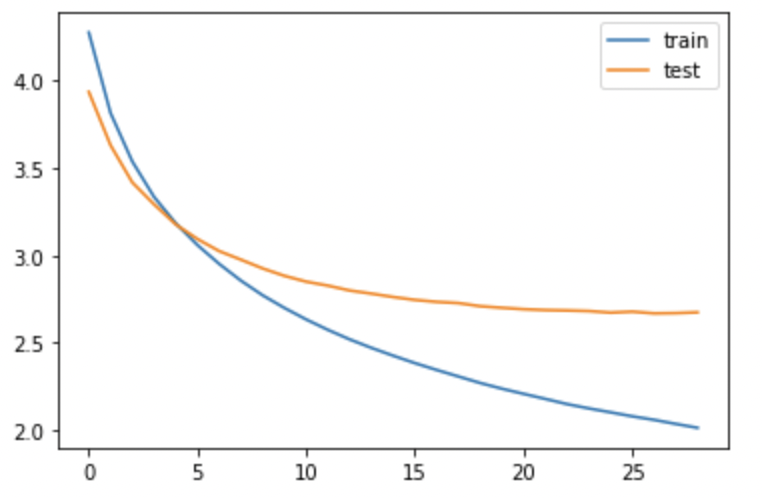
- Early stopping을 이용해서 29번 학습하고 멈췄으며, loss는 제대로 줄어드는 것으로 보아 모델이 안정적으로 수렴하였음을 알 수 있다.

### 추상적 요약
- 
원문 : actress sushmita sen shared pictures little black dress instagram message body positivity wrote perfect every size wrote live healthy body let one tell otherwise actress paired dress black sunglasses   
실제 요약 : sushmita shares pics in dress to talk about body   
예측 요약 :  sushmita shares picture with her sister on her dress  


핵심단어인 sushmita, shares, picture, dress가 모두 들어가 있으며, 예측 요약의 문법이 틀리지 않고 제대로 구사되었음을 알 수 있다.  
아쉬운 점은 원문에는 없는 동생이라는 단어가 추가됨으로써 거짓인 정보가 되었다는 것이다.

- 
원문 : aam aadmi party thursday opposed lieutenant governor anil baijal move withdraw powers department related standing committees claimed protecting delhi government erring officials aap leaders said whenever senior officials summoned committees regarding execution duties would grant leave without informing chief minister   
실제 요약 : protecting officials of delhi govt claims aap   
예측 요약 :  aap aap leader seeks permission to move to delhi govt  


핵심단어인 aap과 delhigovt은 잘 찾았으나, claims가 빠져 있다.  
aap이라는 단어가 두번 반복되는 문제가 있으며, 문법은 틀리지 않고 완성되어 있지만, 전혀 원문에 없는 내용을 내포하고 있다.
제대로 된 요약이라고 볼 수 없을 것 같다.


전반적으로 핵심단어들은 제대로 내포하고 있고, 문법의 완성도도 높은 경우가 많지만, 내용은 아예 다른 경우가 많다.
아마도 더 많은 데이터를 가지게 된다면, 더 정확하게 결과를 낼 수 있을 것 같다.

### 추출적 요약

- 원문 : 
  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.  
실제 요약 : 
  upGrad learner switches to career in ML & Al with 90% salary hike  
예측 요약 : 
  upGrad's Online Power Learning has powered 3 lakh+ careers.  


핵심단어인 upGrad와 career는 들어가 있으나, ML & AI가 빠져있으며, 문법은 얼추 맞지만 엉뚱한 내용으로 문장을 예측했다.
  
  
- 원문 : 
  Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman. But in this case, we need to reserve our judgment," she added. Hirani has been accused by an assistant who worked in 'Sanju'.
실제 요약 : 
  Have known Hirani for yrs, what if MeToo claims are not true: Sonam
예측 요약 : 
  Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman.
  
ratio를 0.5로 했더니 다소 길게 예측한 것 같다.
요약이라고 할 수 없을만큼 길지만, 핵심단어와 문법은 다 맞다.


요약이 길게 되는 것과 짧게 되는 것 둘 다 있어서 어느 정도 길이로 예측하는지 감이 안잡힌다.
아예 다른 내용으로 요약하지는 않지만, 핵심적인 내용으로 문장을 구사하지는 못한다.
문법은 어느정도 완성도가 있지만, 어설픈 면이 많다.

#### 결론
- 추상적 요약은 추출적 요약과 달리 아예 다른 단어를 가지고 와서 정보 자체가 달라지는 경우가 있지만, 더 말이 되는 문장들로 요약한 것 같다. (문법도 얼추 맞고 핵심단어도 잘 내포하고 있는 듯 하다). 
- 두 방법 모두 문법은 어느정도 잘 맞는다.
- 이 방법 그대로 실생활에서 사용하기는 어렵고 다른 기술 예를 들어 transformer, BART 등을 이용하여 모델을 설계해야 할 것 같다.
